In [15]:
from PySDM.backends.default import Default
from PySDM.physics.constants import si
from PySDM.physics import constants as const, formulae as fml
from PySDM.dynamics.condensation import condensation
from PySDM.dynamics import Condensation
from PySDM.initialisation.spectra import Lognormal
from PySDM.particles_builder import ParticlesBuilder
from PySDM.environments import MoistLagrangianParcelAdiabatic
from PySDM.dynamics import Coalescence
from PySDM.initialisation.spectral_sampling import constant_multiplicity
from PySDM.dynamics.coalescence.kernels import Golovin
from PySDM.initialisation.moist_environment_init import moist_environment_init
from PySDM.dynamics.condensation import condensation
from PySDM.initialisation.r_wet_init import r_wet_init
from PySDM.initialisation.multiplicities import discretise_n
from PySDM.dynamics.chemical_reaction.products.particle_dry_size_spectrum import ParticlesDrySizeSpectrum
from PySDM.dynamics.chemical_reaction.oxidation.dynamic import ChemicalReaction, COMPOUNDS
from PySDM.dynamics.chemical_reaction.oxidation.constants import dry_air_d
from PySDM.environments.products.dry_air_density import DryAirDensity


import numpy as np

minute = 60 * si.seconds

class SetupAdiabatic:
    r_min = 1e-2 * si.micrometre
    r_max = 50 * si.micrometre
    
    n_sd = 2 ** 10
    dt = 0.4 * si.s # Four times bigger than in the paper

    mass_of_dry_air = 100 * si.kilogram
    T0 = 285.2 * si.K
    p0 = 950 * si.hectopascals
    RH0 = 0.95
    q0 = const.eps / (p0 / RH0 / fml.pvs(T0) - 1)
    z0 = 600 * si.metres
    
    up_velocity = 0.5 * si.m / si.s
    
    mean_rad = 0.4 * si.micrometre
    geo_stdev = 2
    tot_aer_conc = 566 / si.cm ** 3 / const.rho_STP
    
    kappa = 0.61
    
    seed = 44
         
    time = 2400 * si.s
    steps = int(time / dt)
    steps_per_sample = 1
    
    backend = Default
    spectrum = Lognormal(norm_factor=tot_aer_conc, m_mode=mean_rad, s_geom=geo_stdev)
    
    rho = 1000 * si.kilogram / si.metre**3

    adaptive = True
    coord = "volume logarithm"
    rtol_x = condensation.default_rtol_x
    rtol_thd = condensation.default_rtol_thd

    radius_bins_edges = np.logspace(np.log10(r_min / si.micrometre), np.log10(r_max / si.micrometre), num=64, endpoint=True) * si.micrometre

    t0 = 1200 * si.second
    f0 = 1 / 1000 * si.hertz
    
    @staticmethod
    def w(t):
        return 0.5 * (np.where(t < SetupAdiabatic.t0, 1, np.sign(-np.sin(2*np.pi * SetupAdiabatic.f0 * (t-SetupAdiabatic.t0))))) * si.metre / si.second



In [22]:
def getstate(setup, particles):
    return particles.products["Dry Radius Spectrum"].get(fml.volume(setup.radius_bins_edges)) * setup.rho

def get_ppb_so2(sdchem, drop, particles):
    # 3 - SO2
    # TODO verify this is actually valid
    dv = particles.environment.mass_of_dry_air / particles.products["rhod"].get()
    
    so2 = sdchem.environment[sdchem.environment_indices["SO2"]]
    drop_so2 = np.dot(drop, np.ones_like(particles.state["n"])) / dv
    return (so2 * sdchem.ideal_gas_volume,
            (drop_so2) * sdchem.ideal_gas_volume,
            (so2 + drop_so2 ) * sdchem.ideal_gas_volume)

radii = []

def run(setup):
    particles_builder = ParticlesBuilder(n_sd=setup.n_sd, backend=setup.backend)
    dry_radii, n = constant_multiplicity(setup.n_sd, setup.spectrum,
                                                              (setup.r_min, setup.r_max))
    
    n = discretise_n(n)
    
    particles_builder.set_environment(MoistLagrangianParcelAdiabatic, {
        "dt": setup.dt,
        "mass_of_dry_air": setup.mass_of_dry_air,
        "p0": setup.p0,
        "q0": setup.q0,
        "T0": setup.T0,
        "w": setup.w,
        "z0": setup.z0
    })
    
    environment = particles_builder.particles.environment
    dry_v = fml.volume(radius=dry_radii)
    r_wet = r_wet_init(dry_radii, environment, np.zeros_like(n), setup.kappa)
    
    particles_builder.register_dynamic(Condensation, {
        "kappa": setup.kappa,
        "coord": setup.coord,
        "adaptive": setup.adaptive,
        "rtol_x": setup.rtol_x,
        "rtol_thd": setup.rtol_thd,
    })
    
    particles_builder.register_dynamic(ChemicalReaction, {"dissolve_steps": 5, "oxidize_steps": 5})
    
    wet_v = fml.volume(radius=r_wet)
    
    attributes = {
        "n": n,
        "dry volume": dry_v,
        "volume": wet_v,
        **ChemicalReaction.get_starting_amounts(dry_v, wet_v)
    }
    products = {ParticlesDrySizeSpectrum: {}, DryAirDensity: {}}
    
    particles = particles_builder.get_particles(attributes, products)
    
    times = []
    products = []
    concs = []
    radii.append(getstate(setup, particles))
    for i in range(0, setup.steps // setup.steps_per_sample):
        state = particles.state
        
        particles.run(setup.steps_per_sample)
        times.append(i * setup.steps_per_sample * setup.dt)
        
        # HACK
        sdchem = particles.dynamics[str(ChemicalReaction)].sdchem
        
        products.append([
            # LWC
            setup.rho * np.dot(state["n"], state["volume"]),
            # SO2
            get_ppb_so2(sdchem, state["SO2"], particles),
            # pH, +3 to account for unit (si: m^3, traditional: L)
            -np.log10(np.mean(state["Hp"] / state["volume"])) + 3,
        ])

        concs.append([np.mean(state[x]) for x in COMPOUNDS.keys()])
        
        print(-np.log10(np.mean(state["Hp"] / state["volume"])) + 3)
        if i > 0 and i % 400 == 0:
            radii.append(getstate(setup, particles)) 
    
    radii.append(getstate(setup, particles)) 

    return ((times, products), radii, concs)

In [23]:
setup = SetupAdiabatic()
res = run(setup)

Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.12060684032466851
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.11986437982081899
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.11905140350002208
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.11821484273949512
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 3.4631369997691906e-14
-0.11736700182188287
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.1165124138067748
Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.11565311547785306
Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.11479016223955174
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.11392414493641834
Chemistry total took 0.085s, skipped 1024/1024
Ammonium

Chemistry total took 0.094s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.045894642635859295
Chemistry total took 0.100s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.044865565601722945
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.04383391514122037
Chemistry total took 0.109s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.042799682193257915
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.04176285505549737
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.04072341677306213
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.039681358074350914
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.03863666436709856
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
-0.037589322665890545
Chemistry total took 0.086s, skipped 1024/1024
Amm

Chemistry total took 0.123s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.0431950872911373
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.0444705961789964
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.04575000256784367
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.04703333423297584
Chemistry total took 0.111s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.048320613784776256
Chemistry total took 0.102s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.04961186076527646
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.05090710704818768
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.052206369578717826
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.05350967796225259
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 3.

Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.159863565285153
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.16154614540487833
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.16323540200241382
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.16493138046395028
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.16663413799827964
Chemistry total took 0.124s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.16834372584893975
Chemistry total took 0.198s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.1700601966936004
Chemistry total took 0.166s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.171783604983609
Chemistry total took 0.163s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.17351400387472316
Chemistry total took 0.134s, skipped 1024/1024
Ammonium conc: 3.46313

Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.3234033815524775
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.32586195948730223
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.32833435813320877
Chemistry total took 0.104s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.3308207259697018
Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.3333212138861814
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.3358359722045834
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.3383651588629637
Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.340908927353043
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.34346744051590417
Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 3.4631369

Chemistry total took 0.111s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.5853804296251943
Chemistry total took 0.116s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.5897475839112079
Chemistry total took 0.111s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.594154615283546
Chemistry total took 0.121s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.5986021731152578
Chemistry total took 0.125s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.6030909090863412
Chemistry total took 0.117s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.607621496450315
Chemistry total took 0.107s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.6121946239692426
Chemistry total took 0.108s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.6168109864967009
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
0.6214713019225666
Chemistry total took 0.107s, skipped 1024/1024
Ammonium conc: 3.46313699976

Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.1601243643456611
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.170956854378256
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.1818733278374451
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.1928685294053352
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.203936664310693
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.2150713936219204
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.226265824561344
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.2375125339572022
Chemistry total took 0.124s, skipped 1024/1024
Ammonium conc: 3.463136999769192e-14
1.2488035827236805
Chemistry total took 0.134s, skipped 1024/1024
Ammonium conc: 3.463136999769

Chemistry total took 0.212s, skipped 946/1024
Ammonium conc: 3.368556090896907e-14
1.9877480636560048
Chemistry total took 0.411s, skipped 956/1024
Ammonium conc: 3.365330143364147e-14
1.9962636985246318
Chemistry total took 0.388s, skipped 957/1024
Ammonium conc: 3.3615178896772644e-14
2.00444587387115
Chemistry total took 0.225s, skipped 949/1024
Ammonium conc: 3.3578945255373714e-14
2.0126187173839183
Chemistry total took 0.236s, skipped 949/1024
Ammonium conc: 3.354287077875509e-14
2.0207838550377026
Chemistry total took 0.202s, skipped 944/1024
Ammonium conc: 3.350429554155084e-14
2.0289429573095044
Chemistry total took 0.197s, skipped 947/1024
Ammonium conc: 3.3466621551525625e-14
2.0370977616058332
Chemistry total took 0.212s, skipped 952/1024
Ammonium conc: 3.342704316519665e-14
2.0452500767227173
Chemistry total took 0.201s, skipped 945/1024
Ammonium conc: 3.3386021130758877e-14
2.053401759486429
Chemistry total took 0.194s, skipped 952/1024
Ammonium conc: 3.3345780397381935e-

Chemistry total took 0.241s, skipped 918/1024
Ammonium conc: 2.9697207576887335e-14
2.542000957891737
Chemistry total took 0.267s, skipped 909/1024
Ammonium conc: 2.9636863748403224e-14
2.5467955075541204
Chemistry total took 0.237s, skipped 916/1024
Ammonium conc: 2.9588521960550894e-14
2.552755096144552
Chemistry total took 0.246s, skipped 918/1024
Ammonium conc: 2.9533576496474604e-14
2.557533658523928
Chemistry total took 0.255s, skipped 911/1024
Ammonium conc: 2.9482446532464254e-14
2.5635061985241867
Chemistry total took 0.276s, skipped 908/1024
Ammonium conc: 2.942627415069897e-14
2.5694968756189422
Chemistry total took 0.235s, skipped 920/1024
Ammonium conc: 2.936279021035591e-14
2.5742593681518886
Chemistry total took 0.243s, skipped 914/1024
Ammonium conc: 2.9316084200252984e-14
2.5802685591408654
Chemistry total took 0.252s, skipped 909/1024
Ammonium conc: 2.9256511772930967e-14
2.5850199391518407
Chemistry total took 0.254s, skipped 907/1024
Ammonium conc: 2.920161796559455

Chemistry total took 0.297s, skipped 908/1024
Ammonium conc: 2.5619213025177728e-14
2.912232432179062
Chemistry total took 0.264s, skipped 908/1024
Ammonium conc: 2.5563530468719966e-14
2.914518033424508
Chemistry total took 0.276s, skipped 913/1024
Ammonium conc: 2.5539388825973085e-14
2.9195266588428543
Chemistry total took 0.281s, skipped 902/1024
Ammonium conc: 2.548222225686168e-14
2.9217880731871486
Chemistry total took 0.258s, skipped 913/1024
Ammonium conc: 2.5451202858612456e-14
2.926817697089012
Chemistry total took 0.259s, skipped 914/1024
Ammonium conc: 2.5399524294361836e-14
2.92905523633844
Chemistry total took 0.246s, skipped 912/1024
Ammonium conc: 2.5368625232231987e-14
2.934107669474132
Chemistry total took 0.250s, skipped 913/1024
Ammonium conc: 2.531714910788592e-14
2.936321538642168
Chemistry total took 0.249s, skipped 909/1024
Ammonium conc: 2.5262235208244098e-14
2.941398715983302
Chemistry total took 0.281s, skipped 912/1024
Ammonium conc: 2.523128508698228e-14


Chemistry total took 0.273s, skipped 916/1024
Ammonium conc: 2.2569385141377382e-14
3.1645871522433295
Chemistry total took 0.235s, skipped 925/1024
Ammonium conc: 2.252299085336103e-14
3.166116659526974
Chemistry total took 0.312s, skipped 924/1024
Ammonium conc: 2.2491334807397682e-14
3.167639934650337
Chemistry total took 0.270s, skipped 924/1024
Ammonium conc: 2.2477538162798043e-14
3.174059584252592
Chemistry total took 0.344s, skipped 916/1024
Ammonium conc: 2.2426618784587954e-14
3.175567329617561
Chemistry total took 0.377s, skipped 922/1024
Ammonium conc: 2.239714560698683e-14
3.1770690055830935
Chemistry total took 0.284s, skipped 919/1024
Ammonium conc: 2.2374813007583555e-14
3.1785646203232707
Chemistry total took 0.223s, skipped 927/1024
Ammonium conc: 2.2334025947402023e-14
3.180054237753564
Chemistry total took 0.239s, skipped 930/1024
Ammonium conc: 2.2324473471871112e-14
3.1865771690224913
Chemistry total took 0.254s, skipped 924/1024
Ammonium conc: 2.2285488893027754e

Chemistry total took 0.210s, skipped 936/1024
Ammonium conc: 2.0364867550287717e-14
3.3467855762261616
Chemistry total took 0.222s, skipped 929/1024
Ammonium conc: 2.0343056910155685e-14
3.3478826399382604
Chemistry total took 0.231s, skipped 932/1024
Ammonium conc: 2.0317133542163354e-14
3.348976041976739
Chemistry total took 0.226s, skipped 938/1024
Ammonium conc: 2.03021592479951e-14
3.3500658218113673
Chemistry total took 0.279s, skipped 939/1024
Ammonium conc: 2.02784101439749e-14
3.3511519725679952
Chemistry total took 0.311s, skipped 935/1024
Ammonium conc: 2.0260745455051304e-14
3.352234497977423
Chemistry total took 0.344s, skipped 931/1024
Ammonium conc: 2.025901097891092e-14
3.360838139604877
Chemistry total took 0.243s, skipped 935/1024
Ammonium conc: 2.022572781954558e-14
3.3619106109651264
Chemistry total took 0.220s, skipped 931/1024
Ammonium conc: 2.020290415327493e-14
3.3629795335710373
Chemistry total took 0.222s, skipped 936/1024
Ammonium conc: 2.015294257694061e-14


Chemistry total took 0.324s, skipped 941/1024
Ammonium conc: 1.873957788842604e-14
3.484958879472269
Chemistry total took 0.256s, skipped 937/1024
Ammonium conc: 1.8721031039705192e-14
3.4858018711623386
Chemistry total took 0.305s, skipped 955/1024
Ammonium conc: 1.8720172315214715e-14
3.486642698296452
Chemistry total took 0.327s, skipped 936/1024
Ammonium conc: 1.8711468246801196e-14
3.4874812175763306
Chemistry total took 0.223s, skipped 942/1024
Ammonium conc: 1.869879306813469e-14
3.488317551290259
Chemistry total took 0.196s, skipped 954/1024
Ammonium conc: 1.869944962447912e-14
3.489151733056921
Chemistry total took 0.218s, skipped 946/1024
Ammonium conc: 1.8674506469345175e-14
3.4899836966841176
Chemistry total took 0.204s, skipped 939/1024
Ammonium conc: 1.866992642081267e-14
3.490813444617803
Chemistry total took 0.193s, skipped 950/1024
Ammonium conc: 1.8655892450035662e-14
3.4916410909550057
Chemistry total took 0.203s, skipped 943/1024
Ammonium conc: 1.864058474741468e-14

Chemistry total took 0.239s, skipped 957/1024
Ammonium conc: 1.754174253772316e-14
3.591950763282295
Chemistry total took 0.221s, skipped 943/1024
Ammonium conc: 1.7522212442117284e-14
3.5926367229530385
Chemistry total took 0.185s, skipped 958/1024
Ammonium conc: 1.7519781972975044e-14
3.593321308049461
Chemistry total took 0.234s, skipped 945/1024
Ammonium conc: 1.7519697615663103e-14
3.5940043832088975
Chemistry total took 0.229s, skipped 956/1024
Ammonium conc: 1.7506912207475334e-14
3.5946860795444247
Chemistry total took 0.196s, skipped 948/1024
Ammonium conc: 1.750833703258714e-14
3.5953662993631372
Chemistry total took 0.182s, skipped 955/1024
Ammonium conc: 1.7508506549612084e-14
3.6092773942862184
Chemistry total took 0.201s, skipped 946/1024
Ammonium conc: 1.7481495885398535e-14
3.609952240242311
Chemistry total took 0.192s, skipped 954/1024
Ammonium conc: 1.7432494630172513e-14
3.6106257333423204
Chemistry total took 0.201s, skipped 945/1024
Ammonium conc: 1.738248066228352

Chemistry total took 0.203s, skipped 943/1024
Ammonium conc: 1.6556509912489967e-14
3.6862446670247895
Chemistry total took 0.178s, skipped 961/1024
Ammonium conc: 1.653965364278743e-14
3.6868242935411217
Chemistry total took 0.187s, skipped 961/1024
Ammonium conc: 1.6527282873336732e-14
3.6874029382818945
Chemistry total took 0.195s, skipped 954/1024
Ammonium conc: 1.6528830850766004e-14
3.6879805417438067
Chemistry total took 0.206s, skipped 955/1024
Ammonium conc: 1.6517106006750484e-14
3.6885571656854963
Chemistry total took 0.204s, skipped 954/1024
Ammonium conc: 1.651157537584324e-14
3.6891327881911202
Chemistry total took 0.243s, skipped 952/1024
Ammonium conc: 1.6508737185166165e-14
3.689707414844535
Chemistry total took 0.186s, skipped 959/1024
Ammonium conc: 1.650548586388286e-14
3.6902810973415154
Chemistry total took 0.263s, skipped 956/1024
Ammonium conc: 1.6504341818953466e-14
3.707373896447335
Chemistry total took 0.259s, skipped 950/1024
Ammonium conc: 1.646001696349018

Chemistry total took 0.225s, skipped 970/1024
Ammonium conc: 1.5760048196043905e-14
3.7645075473282863
Chemistry total took 0.237s, skipped 951/1024
Ammonium conc: 1.5759281173638516e-14
3.7650126442142424
Chemistry total took 0.219s, skipped 960/1024
Ammonium conc: 1.5753358759896435e-14
3.765517060095188
Chemistry total took 0.225s, skipped 962/1024
Ammonium conc: 1.5737717389573012e-14
3.7660207547464135
Chemistry total took 0.224s, skipped 949/1024
Ammonium conc: 1.5718478775819006e-14
3.7862509087022356
Chemistry total took 0.189s, skipped 968/1024
Ammonium conc: 1.5688704424878395e-14
3.7867507831713962
Chemistry total took 0.203s, skipped 953/1024
Ammonium conc: 1.566137020184656e-14
3.7872498345283336
Chemistry total took 0.184s, skipped 966/1024
Ammonium conc: 1.5635161362932177e-14
3.78774824692617
Chemistry total took 0.249s, skipped 946/1024
Ammonium conc: 1.5609985633768935e-14
3.788245809751658
Chemistry total took 0.194s, skipped 972/1024
Ammonium conc: 1.558772567152708

Chemistry total took 0.214s, skipped 966/1024
Ammonium conc: 1.5018704860671654e-14
3.8445224652515764
Chemistry total took 0.224s, skipped 968/1024
Ammonium conc: 1.5010312793495994e-14
3.8449703279991456
Chemistry total took 0.255s, skipped 947/1024
Ammonium conc: 1.5007773724980666e-14
3.8454174821645046
Chemistry total took 0.199s, skipped 968/1024
Ammonium conc: 1.5003486382671262e-14
3.8458642044596467
Chemistry total took 0.179s, skipped 958/1024
Ammonium conc: 1.4991986902716064e-14
3.8463102957013695
Chemistry total took 0.220s, skipped 968/1024
Ammonium conc: 1.4988771928452015e-14
3.846755885391452
Chemistry total took 0.264s, skipped 950/1024
Ammonium conc: 1.497742709158214e-14
3.8472007971470163
Chemistry total took 0.209s, skipped 970/1024
Ammonium conc: 1.497863097064145e-14
3.847645268744486
Chemistry total took 0.214s, skipped 955/1024
Ammonium conc: 1.4958181064083267e-14
3.8480890906423757
Chemistry total took 0.186s, skipped 964/1024
Ammonium conc: 1.49596644962423

Chemistry total took 0.202s, skipped 954/1024
Ammonium conc: 1.4476692533754472e-14
3.9033302644474857
Chemistry total took 0.166s, skipped 965/1024
Ammonium conc: 1.4460839962582326e-14
3.903734450823495
Chemistry total took 0.167s, skipped 967/1024
Ammonium conc: 1.4455613938874097e-14
3.9041381878526065
Chemistry total took 0.195s, skipped 956/1024
Ammonium conc: 1.4457195901586755e-14
3.9045413918637584
Chemistry total took 0.168s, skipped 968/1024
Ammonium conc: 1.4458643762151953e-14
3.9049442240274805
Chemistry total took 0.167s, skipped 967/1024
Ammonium conc: 1.4459256218377626e-14
3.9053465921445554
Chemistry total took 0.174s, skipped 963/1024
Ammonium conc: 1.4444897415332775e-14
3.905748484200954
Chemistry total took 0.181s, skipped 958/1024
Ammonium conc: 1.444436021405044e-14
3.906149890754989
Chemistry total took 0.179s, skipped 960/1024
Ammonium conc: 1.4445255023595142e-14
3.906550850431925
Chemistry total took 0.194s, skipped 967/1024
Ammonium conc: 1.444660510924065

Chemistry total took 0.211s, skipped 968/1024
Ammonium conc: 1.3975696019166065e-14
3.9624667065112695
Chemistry total took 0.162s, skipped 969/1024
Ammonium conc: 1.3977344578514136e-14
3.962834603082829
Chemistry total took 0.185s, skipped 954/1024
Ammonium conc: 1.3979141866035522e-14
3.9632020142353857
Chemistry total took 0.163s, skipped 970/1024
Ammonium conc: 1.396968021459485e-14
3.963569175731578
Chemistry total took 0.193s, skipped 963/1024
Ammonium conc: 1.3955010248756468e-14
3.963935906018893
Chemistry total took 0.171s, skipped 969/1024
Ammonium conc: 1.3950396151825526e-14
3.9643023101454906
Chemistry total took 0.184s, skipped 957/1024
Ammonium conc: 1.3943018453493145e-14
3.964668250937807
Chemistry total took 0.162s, skipped 974/1024
Ammonium conc: 1.3942872504583628e-14
3.965033946820731
Chemistry total took 0.184s, skipped 956/1024
Ammonium conc: 1.3944317489818003e-14
3.9653991310475996
Chemistry total took 0.162s, skipped 973/1024
Ammonium conc: 1.394151281500419e

Chemistry total took 0.165s, skipped 965/1024
Ammonium conc: 1.347460200961887e-14
4.022646977032084
Chemistry total took 0.167s, skipped 966/1024
Ammonium conc: 1.347472001626334e-14
4.022984666684323
Chemistry total took 0.176s, skipped 971/1024
Ammonium conc: 1.3471984316590708e-14
4.023322086287896
Chemistry total took 0.187s, skipped 964/1024
Ammonium conc: 1.3472778147662135e-14
4.023659128838191
Chemistry total took 0.179s, skipped 965/1024
Ammonium conc: 1.3474550291508838e-14
4.023995871189322
Chemistry total took 0.186s, skipped 967/1024
Ammonium conc: 1.3476148549955313e-14
4.024332315196777
Chemistry total took 0.171s, skipped 965/1024
Ammonium conc: 1.3477658466406781e-14
4.024668432342794
Chemistry total took 0.170s, skipped 975/1024
Ammonium conc: 1.3471780640929544e-14
4.025004316317313
Chemistry total took 0.184s, skipped 956/1024
Ammonium conc: 1.3473708892353863e-14
4.025339730669772
Chemistry total took 0.158s, skipped 972/1024
Ammonium conc: 1.34752070113568e-14
4.

Chemistry total took 0.185s, skipped 955/1024
Ammonium conc: 1.3032879191982644e-14
4.086390949625261
Chemistry total took 0.156s, skipped 974/1024
Ammonium conc: 1.303394328681809e-14
4.086702580556427
Chemistry total took 0.182s, skipped 958/1024
Ammonium conc: 1.3035145191461697e-14
4.087013809270105
Chemistry total took 0.162s, skipped 972/1024
Ammonium conc: 1.2999904600792041e-14
4.087324897453804
Chemistry total took 0.162s, skipped 972/1024
Ammonium conc: 1.3001624117121629e-14
4.087635711811672
Chemistry total took 0.199s, skipped 956/1024
Ammonium conc: 1.3002918126355325e-14
4.087946118371177
Chemistry total took 0.165s, skipped 970/1024
Ammonium conc: 1.2991511734099121e-14
4.088256391941069
Chemistry total took 0.176s, skipped 959/1024
Ammonium conc: 1.2993586037202958e-14
4.0885662912513565
Chemistry total took 0.144s, skipped 978/1024
Ammonium conc: 1.299500205047222e-14
4.088876096165817
Chemistry total took 0.174s, skipped 961/1024
Ammonium conc: 1.2996095285662793e-14

Chemistry total took 0.154s, skipped 975/1024
Ammonium conc: 1.2786121781030575e-14
4.155864077269313
Chemistry total took 0.168s, skipped 965/1024
Ammonium conc: 1.2750227650150405e-14
4.156152873541447
Chemistry total took 0.163s, skipped 969/1024
Ammonium conc: 1.2715718098658665e-14
4.156441476032754
Chemistry total took 0.197s, skipped 965/1024
Ammonium conc: 1.2681826768558666e-14
4.156729813206413
Chemistry total took 0.201s, skipped 957/1024
Ammonium conc: 1.2653930369476636e-14
4.157017841150266
Chemistry total took 0.161s, skipped 976/1024
Ammonium conc: 1.2612200820105107e-14
4.157305832194219
Chemistry total took 0.185s, skipped 960/1024
Ammonium conc: 1.261321953793614e-14
4.157593427555167
Chemistry total took 0.167s, skipped 978/1024
Ammonium conc: 1.2585196435332553e-14
4.1578809772660374
Chemistry total took 0.198s, skipped 953/1024
Ammonium conc: 1.2587436985292487e-14
4.158168050722292
Chemistry total took 0.152s, skipped 979/1024
Ammonium conc: 1.2588570704967582e-1

Chemistry total took 0.186s, skipped 955/1024
Ammonium conc: 1.2388480645027111e-14
4.178549233427247
Chemistry total took 0.150s, skipped 976/1024
Ammonium conc: 1.2385333119149102e-14
4.1788208093340256
Chemistry total took 0.194s, skipped 962/1024
Ammonium conc: 1.2386952723122404e-14
4.179092048062421
Chemistry total took 0.158s, skipped 976/1024
Ammonium conc: 1.238840183077333e-14
4.1793632168312485
Chemistry total took 0.192s, skipped 967/1024
Ammonium conc: 1.239036392847497e-14
4.179634095885602
Chemistry total took 0.183s, skipped 965/1024
Ammonium conc: 1.239139371840382e-14
4.179904754595408
Chemistry total took 0.181s, skipped 978/1024
Ammonium conc: 1.2392720864776378e-14
4.180175345468507
Chemistry total took 0.242s, skipped 951/1024
Ammonium conc: 1.2389877912939234e-14
4.180445477673101
Chemistry total took 0.165s, skipped 977/1024
Ammonium conc: 1.2373207752898843e-14
4.180715663133272
Chemistry total took 0.181s, skipped 959/1024
Ammonium conc: 1.2358626266536137e-14

Chemistry total took 0.166s, skipped 977/1024
Ammonium conc: 1.2296288267758469e-14
4.200170861114168
Chemistry total took 0.171s, skipped 960/1024
Ammonium conc: 1.2297087816750629e-14
4.200426763703662
Chemistry total took 0.150s, skipped 979/1024
Ammonium conc: 1.2297736244999849e-14
4.200682664908807
Chemistry total took 0.153s, skipped 973/1024
Ammonium conc: 1.2278281959634315e-14
4.200938335457222
Chemistry total took 0.166s, skipped 967/1024
Ammonium conc: 1.2280215362145719e-14
4.201193764703478
Chemistry total took 0.170s, skipped 964/1024
Ammonium conc: 1.2277584789991171e-14
4.201448990211053
Chemistry total took 0.173s, skipped 960/1024
Ammonium conc: 1.2279267590011426e-14
4.201704004130738
Chemistry total took 0.144s, skipped 981/1024
Ammonium conc: 1.2280126333056718e-14
4.2019590417221515
Chemistry total took 0.168s, skipped 964/1024
Ammonium conc: 1.2282145542932345e-14
4.202213744218087
Chemistry total took 0.147s, skipped 978/1024
Ammonium conc: 1.2283658863730594e-

Chemistry total took 0.172s, skipped 980/1024
Ammonium conc: 1.181644075417054e-14
4.276489191975084
Chemistry total took 0.214s, skipped 963/1024
Ammonium conc: 1.1818618247744326e-14
4.276729065475071
Chemistry total took 0.182s, skipped 969/1024
Ammonium conc: 1.1820560577665499e-14
4.276968862833008
Chemistry total took 0.173s, skipped 965/1024
Ammonium conc: 1.1816717841301259e-14
4.2772084545115
Chemistry total took 0.154s, skipped 974/1024
Ammonium conc: 1.1816590278164957e-14
4.277447993476867
Chemistry total took 0.172s, skipped 962/1024
Ammonium conc: 1.1818516088294307e-14
4.277687240926959
Chemistry total took 0.147s, skipped 979/1024
Ammonium conc: 1.179796558539332e-14
4.277926519976517
Chemistry total took 0.208s, skipped 961/1024
Ammonium conc: 1.1799742936131868e-14
4.278165445303018
Chemistry total took 0.255s, skipped 968/1024
Ammonium conc: 1.1791567442660454e-14
4.278404288581094
Chemistry total took 0.166s, skipped 978/1024
Ammonium conc: 1.1793234589462689e-14
4.

Chemistry total took 0.210s, skipped 960/1024
Ammonium conc: 1.1721346796842655e-14
4.295662290265149
Chemistry total took 0.156s, skipped 973/1024
Ammonium conc: 1.1722927551684481e-14
4.295890083420599
Chemistry total took 0.155s, skipped 976/1024
Ammonium conc: 1.1722575323830338e-14
4.296117773862498
Chemistry total took 0.175s, skipped 962/1024
Ammonium conc: 1.1721690876873742e-14
4.296345172834347
Chemistry total took 0.158s, skipped 972/1024
Ammonium conc: 1.1715016892464003e-14
4.296572544712908
Chemistry total took 0.160s, skipped 968/1024
Ammonium conc: 1.1716812167331887e-14
4.296799727530187
Chemistry total took 0.158s, skipped 972/1024
Ammonium conc: 1.1713520464092543e-14
4.297026811935161
Chemistry total took 0.167s, skipped 969/1024
Ammonium conc: 1.1714635370354232e-14
4.297253724859447
Chemistry total took 0.182s, skipped 972/1024
Ammonium conc: 1.1716493714074092e-14
4.297480527978553
Chemistry total took 0.200s, skipped 969/1024
Ammonium conc: 1.1718462502825467e-1

Chemistry total took 0.198s, skipped 966/1024
Ammonium conc: 1.1703220901605655e-14
4.313670538960038
Chemistry total took 0.177s, skipped 976/1024
Ammonium conc: 1.1693021330012133e-14
4.313887538880436
Chemistry total took 0.180s, skipped 965/1024
Ammonium conc: 1.169441055906923e-14
4.314104289934141
Chemistry total took 0.166s, skipped 976/1024
Ammonium conc: 1.1696106239167318e-14
4.314321030203021
Chemistry total took 0.170s, skipped 970/1024
Ammonium conc: 1.1698015744124468e-14
4.314537580620112
Chemistry total took 0.182s, skipped 962/1024
Ammonium conc: 1.17001826880136e-14
4.314753915530162
Chemistry total took 0.172s, skipped 977/1024
Ammonium conc: 1.1695117542680322e-14
4.314970292866812
Chemistry total took 0.173s, skipped 962/1024
Ammonium conc: 1.1696138143968516e-14
4.315186379394741
Chemistry total took 0.178s, skipped 989/1024
Ammonium conc: 1.169737953300884e-14
4.315402625797465
Chemistry total took 0.215s, skipped 956/1024
Ammonium conc: 1.169976224438954e-14
4.3

Chemistry total took 0.161s, skipped 975/1024
Ammonium conc: 1.1202037989876939e-14
4.4053363458903
Chemistry total took 0.172s, skipped 961/1024
Ammonium conc: 1.120438487104616e-14
4.40554089387628
Chemistry total took 0.150s, skipped 989/1024
Ammonium conc: 1.12026882927113e-14
4.405745683529712
Chemistry total took 0.202s, skipped 953/1024
Ammonium conc: 1.1181804458829305e-14
4.405949915302309
Chemistry total took 0.163s, skipped 976/1024
Ammonium conc: 1.1181660029965742e-14
4.406154316245806
Chemistry total took 0.173s, skipped 971/1024
Ammonium conc: 1.1182329862555089e-14
4.40635853786142
Chemistry total took 0.165s, skipped 972/1024
Ammonium conc: 1.1184276996418094e-14
4.406562660759345
Chemistry total took 0.163s, skipped 971/1024
Ammonium conc: 1.1186051274195107e-14
4.406766659154975
Chemistry total took 0.183s, skipped 958/1024
Ammonium conc: 1.1188354396884358e-14
4.406970378522632
Chemistry total took 0.161s, skipped 981/1024
Ammonium conc: 1.1185020777018968e-14
4.407

Chemistry total took 0.187s, skipped 969/1024
Ammonium conc: 1.1117413734520414e-14
4.421752666594282
Chemistry total took 0.184s, skipped 978/1024
Ammonium conc: 1.1119067572181494e-14
4.421948518486833
Chemistry total took 0.225s, skipped 956/1024
Ammonium conc: 1.112148812467768e-14
4.422143989995909
Chemistry total took 0.173s, skipped 974/1024
Ammonium conc: 1.1123170692541053e-14
4.42233958657294
Chemistry total took 0.168s, skipped 971/1024
Ammonium conc: 1.1125077937435088e-14
4.422535038554319
Chemistry total took 0.158s, skipped 975/1024
Ammonium conc: 1.1109815937573148e-14
4.422730442304303
Chemistry total took 0.176s, skipped 975/1024
Ammonium conc: 1.1111308580261524e-14
4.422925739313113
Chemistry total took 0.200s, skipped 959/1024
Ammonium conc: 1.1113717786833463e-14
4.423120734910181
Chemistry total took 0.193s, skipped 976/1024
Ammonium conc: 1.1114749283968692e-14
4.423315840160691
Chemistry total took 0.189s, skipped 968/1024
Ammonium conc: 1.1116847853957539e-14


Chemistry total took 0.171s, skipped 976/1024
Ammonium conc: 1.110804936942834e-14
4.437470524555756
Chemistry total took 0.173s, skipped 971/1024
Ammonium conc: 1.1109985777877603e-14
4.437658153607644
Chemistry total took 0.177s, skipped 966/1024
Ammonium conc: 1.1111903275319967e-14
4.437845627165466
Chemistry total took 0.164s, skipped 968/1024
Ammonium conc: 1.1111535303508062e-14
4.438033035195633
Chemistry total took 0.155s, skipped 973/1024
Ammonium conc: 1.1113413369018358e-14
4.438220401172745
Chemistry total took 0.158s, skipped 971/1024
Ammonium conc: 1.1098676311889885e-14
4.4384076582865
Chemistry total took 0.159s, skipped 971/1024
Ammonium conc: 1.1100015265202828e-14
4.4385948163825155
Chemistry total took 0.165s, skipped 968/1024
Ammonium conc: 1.1100797963480258e-14
4.438781841089175
Chemistry total took 0.150s, skipped 978/1024
Ammonium conc: 1.1102335545321184e-14
4.438968894911453
Chemistry total took 0.177s, skipped 959/1024
Ammonium conc: 1.1104617413657258e-14


Chemistry total took 0.201s, skipped 976/1024
Ammonium conc: 1.1123767894013755e-14
4.452368873226258
Chemistry total took 0.186s, skipped 967/1024
Ammonium conc: 1.1125306062036386e-14
4.452549075874236
Chemistry total took 0.183s, skipped 963/1024
Ammonium conc: 1.1126446822055123e-14
4.4527291439034435
Chemistry total took 0.171s, skipped 979/1024
Ammonium conc: 1.1128090981148113e-14
4.452909320686029
Chemistry total took 0.183s, skipped 969/1024
Ammonium conc: 1.1129870174002256e-14
4.453089288609475
Chemistry total took 0.161s, skipped 974/1024
Ammonium conc: 1.1130945651095755e-14
4.453269226397909
Chemistry total took 0.180s, skipped 972/1024
Ammonium conc: 1.1132457440158514e-14
4.4534490526319805
Chemistry total took 0.215s, skipped 965/1024
Ammonium conc: 1.1134604871706429e-14
4.453628705533188
Chemistry total took 0.172s, skipped 971/1024
Ammonium conc: 1.1136526931486035e-14
4.4538083505941675
Chemistry total took 0.165s, skipped 976/1024
Ammonium conc: 1.1138272566894757

Chemistry total took 0.221s, skipped 957/1024
Ammonium conc: 1.1180216696914583e-14
4.46669308561091
Chemistry total took 0.286s, skipped 977/1024
Ammonium conc: 1.118156840199147e-14
4.466866610224372
Chemistry total took 0.248s, skipped 968/1024
Ammonium conc: 1.1183574581690282e-14
4.46703994140618
Chemistry total took 0.192s, skipped 981/1024
Ammonium conc: 1.1185112835231093e-14
4.467213351830631
Chemistry total took 0.199s, skipped 965/1024
Ammonium conc: 1.1187216034279913e-14
4.467386484872259
Chemistry total took 0.217s, skipped 975/1024
Ammonium conc: 1.1188967392630033e-14
4.467559657087225
Chemistry total took 0.194s, skipped 970/1024
Ammonium conc: 1.1190885259945186e-14
4.46773269069095
Chemistry total took 0.210s, skipped 965/1024
Ammonium conc: 1.1186643466950673e-14
4.467905588166918
Chemistry total took 0.186s, skipped 979/1024
Ammonium conc: 1.1188108258751302e-14
4.468078571577122
Chemistry total took 0.207s, skipped 959/1024
Ammonium conc: 1.1189041712797e-14
4.468

Chemistry total took 0.161s, skipped 976/1024
Ammonium conc: 1.0545365665302825e-14
4.589874269458959
Chemistry total took 0.190s, skipped 959/1024
Ammonium conc: 1.0547928596241807e-14
4.59003870248808
Chemistry total took 0.174s, skipped 968/1024
Ammonium conc: 1.0548911199069166e-14
4.590203214028682
Chemistry total took 0.167s, skipped 973/1024
Ammonium conc: 1.0550857661548938e-14
4.5903677230311475
Chemistry total took 0.161s, skipped 974/1024
Ammonium conc: 1.0552822093823867e-14
4.590532169061877
Chemistry total took 0.140s, skipped 983/1024
Ammonium conc: 1.05544061285084e-14
4.590696675797218
Chemistry total took 0.175s, skipped 960/1024
Ammonium conc: 1.0556788364392749e-14
4.590860759133809
Chemistry total took 0.153s, skipped 975/1024
Ammonium conc: 1.0535814730683932e-14
4.591025012298402
Chemistry total took 0.220s, skipped 959/1024
Ammonium conc: 1.0538082322537656e-14
4.591188942067566
Chemistry total took 0.208s, skipped 978/1024
Ammonium conc: 1.0539119763157412e-14


Chemistry total took 0.198s, skipped 970/1024
Ammonium conc: 1.0505808640669165e-14
4.60313489254056
Chemistry total took 0.229s, skipped 969/1024
Ammonium conc: 1.0507966011999902e-14
4.6032936877011545
Chemistry total took 0.183s, skipped 971/1024
Ammonium conc: 1.0509760453641724e-14
4.603452449437422
Chemistry total took 0.171s, skipped 968/1024
Ammonium conc: 1.051128899476206e-14
4.603611098015607
Chemistry total took 0.207s, skipped 973/1024
Ammonium conc: 1.0512982511321076e-14
4.603769751715856
Chemistry total took 0.191s, skipped 971/1024
Ammonium conc: 1.0512192348740188e-14
4.603928308964912
Chemistry total took 0.271s, skipped 968/1024
Ammonium conc: 1.0514383148677029e-14
4.60408674911984
Chemistry total took 0.244s, skipped 982/1024
Ammonium conc: 1.0516026891259602e-14
4.604245335640588
Chemistry total took 0.253s, skipped 961/1024
Ammonium conc: 1.0517987126646716e-14
4.6044035327031985
Chemistry total took 0.167s, skipped 970/1024
Ammonium conc: 1.0502196807539376e-14

Chemistry total took 0.166s, skipped 970/1024
Ammonium conc: 1.0521778756523857e-14
4.615783457345906
Chemistry total took 0.170s, skipped 971/1024
Ammonium conc: 1.051873869372456e-14
4.6159369608378045
Chemistry total took 0.175s, skipped 982/1024
Ammonium conc: 1.0520355126845282e-14
4.6160905595954045
Chemistry total took 0.200s, skipped 955/1024
Ammonium conc: 1.052131148531662e-14
4.616243694214169
Chemistry total took 0.166s, skipped 970/1024
Ammonium conc: 1.0523282876962917e-14
4.61639699110743
Chemistry total took 0.163s, skipped 972/1024
Ammonium conc: 1.0525089274451813e-14
4.616550252877429
Chemistry total took 0.153s, skipped 977/1024
Ammonium conc: 1.0526895626645905e-14
4.616703523847406
Chemistry total took 0.194s, skipped 966/1024
Ammonium conc: 1.0514673703734842e-14
4.616856573418364
Chemistry total took 0.233s, skipped 974/1024
Ammonium conc: 1.0515788431680998e-14
4.617009674802372
Chemistry total took 0.206s, skipped 967/1024
Ammonium conc: 1.0517974318214455e-14

Chemistry total took 0.210s, skipped 966/1024
Ammonium conc: 1.0558927311333328e-14
4.62801478817452
Chemistry total took 0.200s, skipped 980/1024
Ammonium conc: 1.0560588088692961e-14
4.628163449242669
Chemistry total took 0.260s, skipped 961/1024
Ammonium conc: 1.0562958996491071e-14
4.628311769367659
Chemistry total took 0.214s, skipped 979/1024
Ammonium conc: 1.0563962462248649e-14
4.628460298896142
Chemistry total took 0.193s, skipped 965/1024
Ammonium conc: 1.0566178190221841e-14
4.628608556906787
Chemistry total took 0.194s, skipped 973/1024
Ammonium conc: 1.0568100153054262e-14
4.628756880471325
Chemistry total took 0.199s, skipped 971/1024
Ammonium conc: 1.0570074647944087e-14
4.628905115259641
Chemistry total took 0.224s, skipped 965/1024
Ammonium conc: 1.0566020833573828e-14
4.629053204560674
Chemistry total took 0.227s, skipped 970/1024
Ammonium conc: 1.056801157080347e-14
4.629201301513768
Chemistry total took 0.228s, skipped 973/1024
Ammonium conc: 1.0569896226610761e-14


Chemistry total took 0.179s, skipped 962/1024
Ammonium conc: 1.0626892074362114e-14
4.640000120958897
Chemistry total took 0.168s, skipped 975/1024
Ammonium conc: 1.0628643732576157e-14
4.640144007634346
Chemistry total took 0.161s, skipped 981/1024
Ammonium conc: 1.0630219615368269e-14
4.640287920395374
Chemistry total took 0.205s, skipped 965/1024
Ammonium conc: 1.0632373387125522e-14
4.640431539911868
Chemistry total took 0.220s, skipped 974/1024
Ammonium conc: 1.0634144604329912e-14
4.640575238651381
Chemistry total took 0.183s, skipped 964/1024
Ammonium conc: 1.0635964874708296e-14
4.640718736070581
Chemistry total took 0.200s, skipped 970/1024
Ammonium conc: 1.0627922922989e-14
4.640862273120472
Chemistry total took 0.220s, skipped 967/1024
Ammonium conc: 1.0629821759698449e-14
4.641005707036749
Chemistry total took 0.225s, skipped 964/1024
Ammonium conc: 1.0631075182208713e-14
4.641149038108322
Chemistry total took 0.208s, skipped 976/1024
Ammonium conc: 1.0632838238024621e-14
4

Chemistry total took 0.147s, skipped 983/1024
Ammonium conc: 1.0707295231598616e-14
4.6513285098832835
Chemistry total took 0.158s, skipped 980/1024
Ammonium conc: 1.0708872868075216e-14
4.651425372191823
Chemistry total took 0.129s, skipped 995/1024
Ammonium conc: 1.0709792907595169e-14
4.651517297753444
Chemistry total took 0.135s, skipped 987/1024
Ammonium conc: 1.0711124347727581e-14
4.651604063707168
Chemistry total took 0.126s, skipped 995/1024
Ammonium conc: 1.0711330269603059e-14
4.651686050923162
Chemistry total took 0.123s, skipped 997/1024
Ammonium conc: 1.0712147844727265e-14
4.651763270089933
Chemistry total took 0.128s, skipped 995/1024
Ammonium conc: 1.0710127224346712e-14
4.651835807395612
Chemistry total took 0.114s, skipped 1005/1024
Ammonium conc: 1.0702466865676651e-14
4.651903930322606
Chemistry total took 0.115s, skipped 1001/1024
Ammonium conc: 1.0703291192365447e-14
4.651967524172445
Chemistry total took 0.117s, skipped 1012/1024
Ammonium conc: 1.070372732051811

Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6495300961102854
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.649444368024793
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.649357944778819
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.649270842557956
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6491830771492255
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.649094663951866
Chemistry total took 0.109s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.649005617986374
Chemistry total took 0.119s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.648915953903
Chemistry total took 0.109s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.648825685991691
Chemistry total took 0.108s, skipped 1024/1024
Ammonium conc: 1.0707759474

Chemistry total took 0.111s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.641353624696289
Chemistry total took 0.102s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.641241824279017
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.641129897170934
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.641017845584008
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6409056716758155
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.640793377550866
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.640680965261898
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.640568436811148
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6404557941515865
Chemistry total took 0.102s, skipped 1024/1024
Ammonium conc: 1.0707759

Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.63212924995416
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.632011355069499
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.631893410797631
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6317754174285435
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.631657375244618
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.631539284520823
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.631421145524888
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6313029585174785
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.631184723752371
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.07077594

Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.622314019664625
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.622192593979971
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.62207112812446
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.621949622114526
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.621828075965539
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.621706489691849
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.621584863306799
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.6214631968227495
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.621341490251102
Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.131s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.612348511766729
Chemistry total took 0.103s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.612223824909325
Chemistry total took 0.116s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.612099097184704
Chemistry total took 0.154s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.611974328570009
Chemistry total took 0.119s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.611849519042204
Chemistry total took 0.145s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.611724668578077
Chemistry total took 0.098s, skipped 1024/1024
Ammonium conc: 1.0707759474747277e-14
4.611599777154252
Chemistry total took 0.132s, skipped 1024/1024
Ammonium conc: 1.0707759474747277e-14
4.611474844747176
Chemistry total took 0.105s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.611349871333135
Chemistry total took 0.105s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.602114286472542
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.601986204190508
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.60185807880479
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.601729910284455
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.601601698598513
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.601473443715918
Chemistry total took 0.103s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.601345145605565
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.60121680423629
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.601088419576875
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.07077594747

Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.591597237596482
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.591465559208488
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.591333835044958
Chemistry total took 0.110s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.591202065070959
Chemistry total took 0.116s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.591070249251514
Chemistry total took 0.116s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.590938387551596
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.590806479936134
Chemistry total took 0.128s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.590674526370011
Chemistry total took 0.150s, skipped 1024/1024
Ammonium conc: 1.0707759474747275e-14
4.5905425268180675
Chemistry total took 0.115s, skipped 1024/1024
Ammonium conc: 1.07077594

Chemistry total took 0.162s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580644414732923
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580508862632907
Chemistry total took 0.098s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580373261737947
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580237612009229
Chemistry total took 0.101s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580101913407892
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.579966165895024
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.57983036943166
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.579694523978788
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.579558629497349
Chemistry total took 0.103s, skipped 1024/1024
Ammonium conc: 1.0707759474

Chemistry total took 0.115s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.569363568009479
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.569223881276084
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.569084142392428
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.568944351315333
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.568804527447917
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.568664651308438
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.568524722853571
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.568384742039935
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.56824470882409
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474

Chemistry total took 0.108s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.557877736031751
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.557733700292393
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.557589608720016
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5574454612664645
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.557301257883514
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.557156998522878
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.557012683136199
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5568683116750535
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.556723884090953
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759

Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5460257195808875
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.54587699947702
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.545728219429112
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.54557937938978
Chemistry total took 0.095s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.545430479312287
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.54528151915069
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.545132498859227
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.544983418392338
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.544834277704785
Chemistry total took 0.107s, skipped 1024/1024
Ammonium conc: 1.07077594747

Chemistry total took 0.118s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.533627085892984
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.533473275075881
Chemistry total took 0.098s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.533319399733184
Chemistry total took 0.114s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.533165459802881
Chemistry total took 0.105s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5330114552222724
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.532857385928603
Chemistry total took 0.079s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.532703251859068
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.532549052950802
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.53239478914089
Chemistry total took 0.080s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.128s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.521113057517986
Chemistry total took 0.125s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.520953880461726
Chemistry total took 0.119s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.520794633617045
Chemistry total took 0.101s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.520635316914099
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.520475930283771
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.52031647365603
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.520156946961563
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.519997350130137
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.519837683092243
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0707759474

Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.507822435303337
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.507657295434198
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.507492079717447
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.507326788074178
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5071614204253665
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.506995976691856
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.506830456794364
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.50666486065331
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.506499188189826
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.494193811047988
Chemistry total took 0.120s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.494022278690708
Chemistry total took 0.109s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.493850664050247
Chemistry total took 0.110s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.493678967033741
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.493507187546413
Chemistry total took 0.111s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.493335325495239
Chemistry total took 0.115s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.493163380785277
Chemistry total took 0.093s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.492991353323342
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.4928192430147496
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.07077594

Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489116606928089
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.48921425599522
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489314488540749
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489417250459475
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489522488807374
Chemistry total took 0.099s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489630151322848
Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489740186836963
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.489852545303835
Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.48996717768406
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.07077594747

Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.50193036256934
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.502126031885734
Chemistry total took 0.080s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.502322101512836
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5025185606492215
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.502715398713579
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.502912605340529
Chemistry total took 0.095s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.503110170375552
Chemistry total took 0.100s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.503308083871247
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.503506336084375
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.518432205277693
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.518638565096649
Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5188448992604595
Chemistry total took 0.100s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.519051205839259
Chemistry total took 0.125s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.519257482945711
Chemistry total took 0.108s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5194637287341415
Chemistry total took 0.119s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.519669941399688
Chemistry total took 0.133s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.519876119177471
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.520082260341766
Chemistry total took 0.118s, skipped 1024/1024
Ammonium conc: 1.0707759

Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.534752072725521
Chemistry total took 0.126s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.534952736713497
Chemistry total took 0.185s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.535153304677881
Chemistry total took 0.157s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.535353776363852
Chemistry total took 0.125s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.535554151524699
Chemistry total took 0.099s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.535754429920662
Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.535954611320244
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.536154695499562
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.536354682241203
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.070775947

4.550297432479826
Chemistry total took 0.100s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.55049016127886
Chemistry total took 0.118s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.550682788969069
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.55087531559679
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.55106774120909
Chemistry total took 0.105s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.551260065854356
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.551452289582092
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5516444124438555
Chemistry total took 0.093s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.551836434491799
Chemistry total took 0.093s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.552028355779276
Chemistry total took 0.099s, skipped 1024/1024
Ammonium c

Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.565955768325307
Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.566140338507481
Chemistry total took 0.101s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5663248138027575
Chemistry total took 0.114s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.566509194296266
Chemistry total took 0.094s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.566693480073528
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.566877671219688
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.567061767820123
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.56724576996027
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.5674296777265715
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.07077594

Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580606372171333
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580783556825193
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.580960654106368
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.581137664104627
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.581314586909617
Chemistry total took 0.095s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.581491422610848
Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.581668171297713
Chemistry total took 0.121s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.581844833059472
Chemistry total took 0.117s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.582021407985256
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.594512220894493
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.594682688965493
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.594853076445612
Chemistry total took 0.098s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.595023383414614
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.5951936099521475
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.59536375613774
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.5955338220507995
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.595703807770617
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.595873713376364
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.070775947474728e

Chemistry total took 0.101s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.608065632409829
Chemistry total took 0.094s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.608229821211892
Chemistry total took 0.104s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.6083939355145
Chemistry total took 0.103s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.608557975388405
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.608721940904246
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.070775947474728e-14
4.608885832132566
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.609049649143801
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6092133920082885
Chemistry total took 0.093s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.609377060796259
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.070775947474727

Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.620970972296124
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.621129416527032
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.62128779160777
Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.621446097601418
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.621604334570977
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.621762502579349
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.621920601689358
Chemistry total took 0.099s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.622078631963732
Chemistry total took 0.093s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.622236593465114
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474

Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.633433043008004
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.633586147547845
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.633739187717458
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.633892163573339
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6340450751719064
Chemistry total took 0.080s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6341979225695065
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6343507058224045
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.634503424986793
Chemistry total took 0.090s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.634656080118784
Chemistry total took 0.089s, skipped 1024/1024
Ammonium conc: 1.070775

Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.645482520520037
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.645630647910898
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.645778715220993
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.645926722501125
Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.646074669802037
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.646222557174401
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.646370384668826
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.646518152335854
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.646665860225961
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.070775947

Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.657290405188272
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.657433825196048
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.657577189033702
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.657720496747041
Chemistry total took 0.079s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6578637483818195
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.658006943983725
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6581500835984
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.658293167271421
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.65843619504831
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.07077594747

Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.668729249848024
Chemistry total took 0.097s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.668868263750754
Chemistry total took 0.117s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.669007225015703
Chemistry total took 0.100s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.669146133684322
Chemistry total took 0.116s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.669284989798019
Chemistry total took 0.107s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.669423793398146
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6695625445260065
Chemistry total took 0.104s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.669701243222855
Chemistry total took 0.102s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6698398895298965
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759

Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.679822285007072
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.67995716541283
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.680091996382776
Chemistry total took 0.095s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.680226777954546
Chemistry total took 0.120s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.68036151016574
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.680496193053914
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.68063082665658
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.680765411011201
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0707759474747279e-14
4.6808999461552006
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.07077594747

Chemistry total took 0.101s, skipped 1024/1024
Ammonium conc: 1.0690535405943192e-14
4.6901328952464425
Chemistry total took 0.108s, skipped 1024/1024
Ammonium conc: 1.0690535405943192e-14
4.6901880512102965
Chemistry total took 0.124s, skipped 1023/1024
Ammonium conc: 1.069008143129059e-14
4.690239208510498
Chemistry total took 0.131s, skipped 1024/1024
Ammonium conc: 1.069008143129059e-14
4.690286491673754
Chemistry total took 0.141s, skipped 1022/1024
Ammonium conc: 1.068715954857277e-14
4.690329956452186
Chemistry total took 0.095s, skipped 1024/1024
Ammonium conc: 1.068715954857277e-14
4.690369749785628
Chemistry total took 0.099s, skipped 1022/1024
Ammonium conc: 1.0687124384819771e-14
4.690405907301145
Chemistry total took 0.091s, skipped 1023/1024
Ammonium conc: 1.0687159094038394e-14
4.690438548566328
Chemistry total took 0.098s, skipped 1020/1024
Ammonium conc: 1.0687284073966825e-14
4.690467695397432
Chemistry total took 0.133s, skipped 1021/1024
Ammonium conc: 1.06873935523

Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.687159256433313
Chemistry total took 0.122s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.687072847340664
Chemistry total took 0.128s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686985881142457
Chemistry total took 0.132s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686898370684407
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686810328496631
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686721766800709
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686632697517316
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686543132273517
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.686453082411103
Chemistry total took 0.081s, skipped 1024/1024
Ammonium conc: 1.068768361

Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678968187380406
Chemistry total took 0.107s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678860447517544
Chemistry total took 0.103s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678752605241803
Chemistry total took 0.105s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.67864466222276
Chemistry total took 0.116s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.6785366200888685
Chemistry total took 0.112s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678428480428447
Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678320244790667
Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678211914686509
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.678103491589689
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.068768361

Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669889959829991
Chemistry total took 0.098s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669776974810914
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669663945974273
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669550873523926
Chemistry total took 0.085s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669437757658248
Chemistry total took 0.083s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.66932459857026
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669211396447757
Chemistry total took 0.082s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.669098151473439
Chemistry total took 0.084s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.6689848638250275
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.068768361

Chemistry total took 0.095s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.660723181467813
Chemistry total took 0.108s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.660607034869544
Chemistry total took 0.115s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.660490850631627
Chemistry total took 0.126s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.660374628761645
Chemistry total took 0.106s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.660258369266382
Chemistry total took 0.136s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.660142072151826
Chemistry total took 0.102s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.6600257374232115
Chemistry total took 0.101s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.65990936508501
Chemistry total took 0.105s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.65979295514097
Chemistry total took 0.096s, skipped 1024/1024
Ammonium conc: 1.0687683613

Chemistry total took 0.118s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.651313024674948
Chemistry total took 0.098s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.651193858473271
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.651074653720148
Chemistry total took 0.092s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.650955410393049
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.650836128469298
Chemistry total took 0.088s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.650716807926086
Chemistry total took 0.093s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.6505974487404576
Chemistry total took 0.086s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.6504780508893235
Chemistry total took 0.087s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.650358614349461
Chemistry total took 0.091s, skipped 1024/1024
Ammonium conc: 1.0687683

Chemistry total took 0.113s, skipped 1024/1024
Ammonium conc: 1.0687683613845857e-14
4.641655875669543


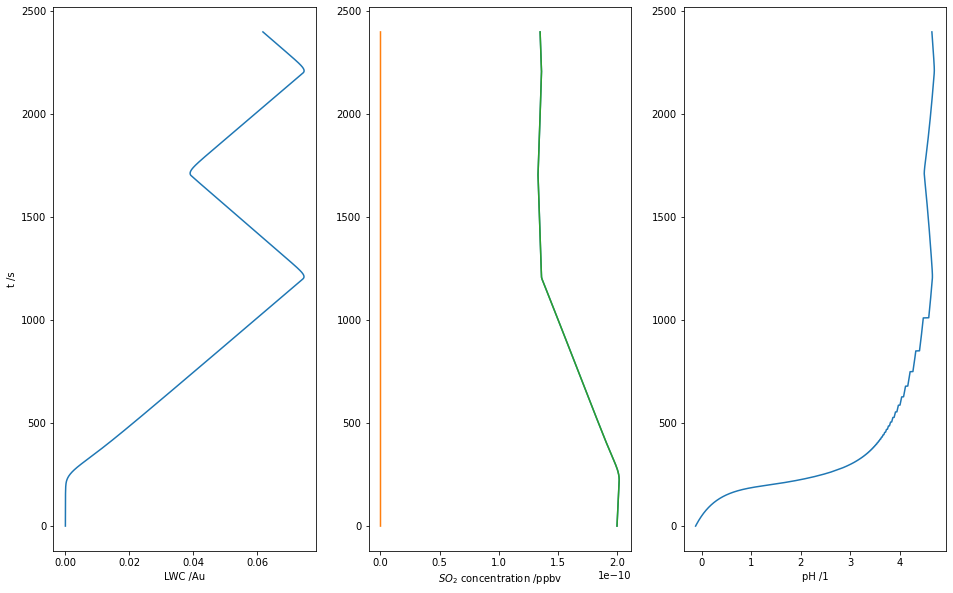

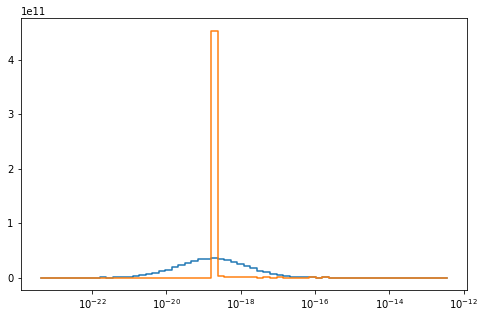

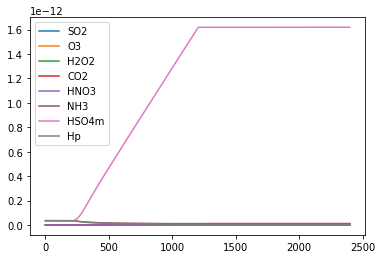

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

plot1, plot2, plot3 = res

times, products = plot1

# Figure 1 reproduction plots

f, axs = plt.subplots(ncols=3)
f.set_size_inches(16, 10)
for ax, p, label in zip(axs, zip(*products), ["LWC /Au", "$SO_2$ concentration /ppbv", "pH /1"]):
    npp = np.array(p)
    npp = np.squeeze(npp)
    ax.plot(npp, times)
    ax.set_xlabel(label)

axs[0].set_ylabel("t /s")
plt.show()

plt.gcf().set_size_inches(8, 5)

# Dry radius distribution

plt.step(fml.volume(setup.radius_bins_edges)[:-1], radii[0])
plt.step(fml.volume(setup.radius_bins_edges)[:-1], radii[-1])
plt.gca().set_xscale("log")
plt.show()

# Concentrations

for comp, lab in zip(np.array(plot3).T, COMPOUNDS.keys()):
    plt.plot(times, comp,label=lab)
plt.legend()
plt.show()

NameError: name 'p3npa' is not defined